In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import os
import h5py
import numpy
import pandas as pd
import pylab as plt
from bilby.core.prior import MultivariateGaussian, MultivariateGaussianDist, PriorDict
import numpy as np
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pycbc.conversions as convert
import bilby
import pycbc
import seaborn as sns

## Load FM errors

In [2]:
def decode_data(data):
    """
    Decodes byte strings or arrays of byte strings from HDF5.
    """
    if isinstance(data, bytes):
        return data.decode('utf-8')
    elif isinstance(data, np.ndarray) and data.dtype.kind in {'S', 'O'}:
        return [d.decode('utf-8') if isinstance(d, bytes) else d for d in data]
    else:
        return data

def load_from_h5_group(group):
    """
    Recursively loads data from an HDF5 group and reconstructs Python objects.
    """
    result = {}

    # Check if this group is an array-style list (all keys are numeric)
    keys = list(group.keys())
    if all(k.isdigit() for k in keys):
        # Treat it as a list, sorted by numeric key
        items = []
        for key in sorted(keys, key=lambda x: int(x)):
            val = group[key]
            if isinstance(val, h5py.Group):
                items.append(load_from_h5_group(val))
            else:
                items.append(decode_data(val[()]))
        return items

    # Otherwise treat as dict
    for key in group:
        item = group[key]
        if isinstance(item, h5py.Group):
            result[key] = load_from_h5_group(item)
        else:
            result[key] = decode_data(item[()])

    return result

def load_results_from_h5(filename):
    """
    Loads structured data from a universally saved HDF5 file.
    """
    with h5py.File(filename, 'r') as f:
        return load_from_h5_group(f)

In [3]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#fm_err_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
#                           'CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_5999_events_pop_from_XPHM_det10.h5')
fm_err_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
                           'LHI_Asharp_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_5945_events_365_days_pop_from_XPHM_det10.h5')

In [4]:
with h5py.File(fm_err_file, 'r') as f:
    print(f.keys())
    print(f['all_inj_params_original'].keys())

<KeysViewHDF5 ['all_inj_params_original', 'cov', 'deriv_variables_in_order', 'errors', 'inj_params', 'netw_snrs', 'sky_locs']>
<KeysViewHDF5 ['PSD_H1', 'PSD_I1', 'PSD_L1', 'SNR_H1', 'SNR_I1', 'SNR_L1', 'SNR_mf_H1', 'SNR_mf_I1', 'SNR_mf_L1', 'SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1', 'SNR_mf_from_opt_network', 'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower', 'f_ref', 'inclination', 'inv_q', 'log_distance', 'mass1', 'mass2', 'mchirp', 'mtotal', 'old_index', 'phi_12', 'phi_jl', 'polarization', 'q', 'ra', 'redshift', 'spin1_a', 'spin1_azimuthal', 'spin1_polar', 'spin1x', 'spin1y', 'spin1z', 'spin2_a', 'spin2_azimuthal', 'spin2_polar', 'spin2x', 'spin2y', 'spin2z', 'srcmass1', 'srcmass2', 'srcmchirp', 'srcmtotal', 'theta_jn', 'time_interval', 'trigger_time']>


In [5]:
fm_results = load_results_from_h5(fm_err_file)

In [6]:
[(key, type(fm_results[key])) for key in fm_results.keys()]

[('all_inj_params_original', dict),
 ('cov', numpy.ndarray),
 ('deriv_variables_in_order', list),
 ('errors', dict),
 ('inj_params', dict),
 ('netw_snrs', numpy.ndarray),
 ('sky_locs', numpy.ndarray)]

In [7]:
for key, val in fm_results.items():
    if isinstance(val, dict):
        fm_results[key] = pd.DataFrame(val)

In [8]:
[(key, type(fm_results[key])) for key in fm_results.keys()]

[('all_inj_params_original', pandas.core.frame.DataFrame),
 ('cov', numpy.ndarray),
 ('deriv_variables_in_order', list),
 ('errors', pandas.core.frame.DataFrame),
 ('inj_params', pandas.core.frame.DataFrame),
 ('netw_snrs', numpy.ndarray),
 ('sky_locs', numpy.ndarray)]

In [9]:
num_events = len(fm_results['cov'])
num_events

5945

In [10]:
fm_results['all_inj_params_original']

,PSD_H1,PSD_I1,PSD_L1,SNR_H1,SNR_I1,SNR_L1,SNR_mf_H1,SNR_mf_I1,SNR_mf_L1,SNR_mf_from_opt_H1,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,ASharp,ASharp,ASharp,5.737929,6.612176,4.515110,4.990872,5.949039,5.529881,6.329655,...,0.141844,0.044275,-0.066039,10.461559,6.814191,7.316764,17.275750,2.565574,499.605743,1.918683e+09
1,ASharp,ASharp,ASharp,6.988540,12.965098,8.170157,7.322774,13.623122,7.544432,6.906180,...,0.365632,0.075366,-0.674420,32.725315,22.754919,23.678153,55.480234,0.920305,577.695695,1.905093e+09
2,ASharp,ASharp,ASharp,6.459393,5.967921,5.250371,7.343760,7.935865,5.183641,6.766340,...,-0.219477,-0.041962,-0.015915,8.392924,6.371731,6.354154,14.764655,2.348911,2222.426320,1.912483e+09
3,ASharp,ASharp,ASharp,14.560698,11.921481,9.715585,14.450827,12.141482,10.467112,13.831645,...,0.017010,-0.046605,-0.084842,13.033235,12.375024,11.055133,25.408259,2.528247,916.054887,1.907989e+09
4,ASharp,ASharp,ASharp,12.978992,20.279215,21.563933,12.611910,18.900234,19.424952,13.724821,...,-0.654972,-0.339141,0.364609,46.235741,27.282979,30.707339,73.518720,1.727465,926.558514,1.918155e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5940,ASharp,ASharp,ASharp,7.498994,7.583466,9.386317,6.598482,7.896857,10.782910,9.419448,...,-0.282208,-0.290758,0.602100,8.334860,3.432170,4.568218,11.767029,2.002046,727.310107,1.920927e+09
5941,ASharp,ASharp,ASharp,10.971796,1.507655,8.514215,8.808629,4.693575,8.927209,10.428617,...,0.038046,0.002885,-0.016180,33.091586,10.912564,16.065265,44.004150,0.383436,35.416407,1.914497e+09
5942,ASharp,ASharp,ASharp,11.669346,5.985211,8.256056,11.708980,6.482828,8.584062,14.417930,...,-0.023523,-0.392819,0.044015,11.621360,9.809821,9.288415,21.431181,1.119219,579.707114,1.900153e+09
5943,ASharp,ASharp,ASharp,9.837806,6.623922,5.562597,8.385219,4.627059,6.927970,10.261099,...,-0.207687,-0.446978,0.037424,36.542956,35.969051,31.561498,72.512006,0.748454,3247.087656,1.911353e+09


### Divide events into mass categories

In [11]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

In [12]:
mass_ranges = ['<40', '40-80', '>80']
fm_mass_divided = {}
print('Total events =', num_events)
for m_range in mass_ranges:
    fm_mass_divided[m_range] = {}
    selected_idxs = slice_mtotal_pop(fm_results['all_inj_params_original']['srcmtotal'], m_range)
    for key in fm_results.keys():
        if 'variables' in key:
            fm_mass_divided[m_range][key] = fm_results[key]
        else:
            fm_mass_divided[m_range][key] = fm_results[key][selected_idxs]
    print(m_range, '=', len(fm_mass_divided[m_range]['cov']))

Total events = 5945
<40 = 3357
40-80 = 2356
>80 = 232


/home/divyajyoti/miniconda3/envs/igwn-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/divyajyoti/miniconda3/envs/igwn-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/divyajyoti/miniconda3/envs/igwn-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


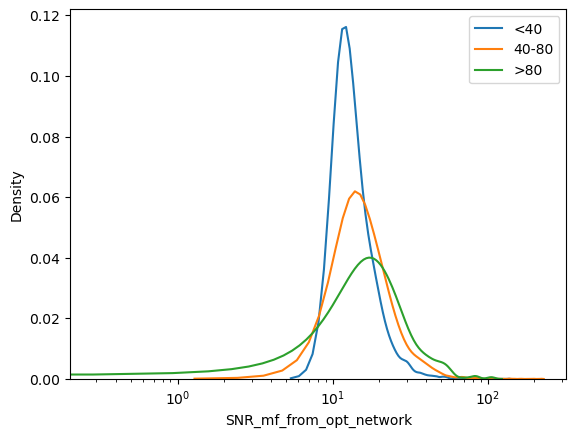

In [13]:
for m_range in fm_mass_divided.keys():
    sns.kdeplot(pd.DataFrame(fm_mass_divided[m_range]['all_inj_params_original'])['SNR_mf_from_opt_network'], 
                label=m_range)
plt.legend(loc=1)
plt.xscale('log')

## Save to h5 file

In [14]:
def save_to_h5_group(group, data, string_dtype, key=None):
    # if key is given, create dataset/group under that name
    if isinstance(data, dict):
        subgroup = group if key is None else group.create_group(str(key))
        for k, v in data.items():
            save_to_h5_group(subgroup, v, string_dtype, k)

    elif isinstance(data, (list, tuple)):
        subgroup = group if key is None else group.create_group(str(key))
        for i, item in enumerate(data):
            save_to_h5_group(subgroup, item, string_dtype, str(i))

    elif isinstance(data, pd.DataFrame):
        subgroup = group if key is None else group.create_group(str(key))
        for col in data.columns:
            subgroup.create_dataset(str(col), data=data[col].to_numpy())

    elif isinstance(data, str):
        if key is None:
            raise ValueError("Strings must be stored with a key")
        group.create_dataset(str(key), data=data, dtype=string_dtype)

    else:
        if key is None:
            raise ValueError("Scalars/arrays must be stored with a key")
        group.create_dataset(str(key), data=np.array(data))


def save_results_to_h5(results, filename):
    dt = h5py.string_dtype(encoding='utf-8')
    with h5py.File(filename, 'w') as f:
        save_to_h5_group(f, results, dt)

In [15]:
fm_err_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/LHI_Asharp_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_5945_events_365_days_pop_from_XPHM_det10.h5'

In [16]:
def mass_range_names(range_name):
    return(range_name.replace('<', 'below_').replace('>', 'above_'))

In [18]:
results_files = {}
for m_range in mass_ranges:
    results_files[m_range] = os.path.join('/'.join(fm_err_file.split('/')[:-1]), 
                                          'mass_bands', 
                                          fm_err_file.split('/')[-1].replace('_5945_events', '').replace('.h5',
                                                                                '_'+mass_range_names(m_range)+'.h5'))
results_files

{'<40': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/mass_bands/LHI_Asharp_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_365_days_pop_from_XPHM_det10_below_40.h5',
 '40-80': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/mass_bands/LHI_Asharp_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_365_days_pop_from_XPHM_det10_40-80.h5',
 '>80': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/mass_bands/LHI_Asharp_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_365_days_pop_from_XPHM_det10_above_80.h5'}

In [19]:
for m_range in mass_ranges:
    save_results_to_h5(fm_mass_divided[m_range], results_files[m_range])